# GNSS时间序列预测深度学习模型

### 本Notebook实现基于深度学习的GNSS时间序列预测，支持LSTM/GRU/TCN/Transformer等模型
## 1. 环境准备

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from utils import split_data
import argparse
import os
from model import *
from utils import *
from pathlib import Path

plt.rcParams['font.family'] = ['SimHei']  # 替换为你的字体名称
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题



# 解析命令行参数

In [2]:
parser = argparse.ArgumentParser()
# data
parser.add_argument('--path', type=str, default='../data/TSI.csv', help="文件路径")
parser.add_argument('--vision', type=bool, default=True)
parser.add_argument('--input_features', type=list, default=['time','period'], help="输入特征")
parser.add_argument('--output_features', type=list, default=['period'], help="输出特征")
parser.add_argument('--window_size', type=int, default=20)
parser.add_argument('--train_test_ratio', type=float, default=0.2)
parser.add_argument('--random_state', type=int, default=34)
# model
parser.add_argument('--model_name', type=str, default='Transformer_ekan', help='模型名称选项，LSTM,LSTM_ekan,TCN_ekan,TCN,Transformer,Transformer_ekan,BiLSTM,BiLSTM_ekan,GRU,GRU_ekan,LSTM_Attention，VanillaLSTM，ConvLSTM，CustomLSTM')
parser.add_argument('--dropout', type=float, default=0.1)
parser.add_argument('--hidden_dim', type=int, default=32)
parser.add_argument('--n_layers', type=int, default=2)
##kan
parser.add_argument('--grid_size', type=int, default=200, help='grid')
##TCN
parser.add_argument('--num_channels', type=list, default=[25, 50, 25])
parser.add_argument('--kernel_size', type=int, default=3)
##transformer
parser.add_argument('--num_heads', type=int, default=8)  # 确保这行存在
parser.add_argument('--hidden_space', type=int, default=32)
# training
parser.add_argument('--num_epochs', type=int, default=10000)
parser.add_argument('--seed', type=int, default=1)
# optimizer
parser.add_argument('--lr', type=float, default=0.001, help='学习率')
# 在参数解析部分添加TimeGNN专用参数
#parser.add_argument('--seq_len', type=int, default=24, help='时间序列长度')
parser.add_argument('--aggregate', type=str, default='last', choices=['mean', 'last'])
parser.add_argument('--keep_self_loops', action='store_true')
parser.add_argument('--enforce_consecutive', action='store_true')
parser.add_argument('--block_size', type=int, default=3)
parser.add_argument('--batch_size', type=int, default=32)  # 新增关键行
parser.add_argument('--seq_len', type=int, default=24)      # TimeGNN专用参数

parser.add_argument('--predict_start', type=int, default=20, help='Start index in original data for prediction')
parser.add_argument('--predict_end', type=int, default=1655, help='End index in original data for prediction')

# 早停参数
parser.add_argument('--use_early_stopping', action='store_true', help='启用早停')
parser.add_argument('--patience', type=int, default=250, help='早停耐心值')
parser.add_argument('--delta', type=float, default=0, help='早停最小变化量')
# 预测数量参数
parser.add_argument('--predict_nums', type=int, nargs='+', default=[30, 60, 360], help='预测长度列表，即为预测天数')
#args = parser.parse_args(args=[''])
args = parser.parse_args(args=['--use_early_stopping'])
args.device = torch.device('cpu')

## 读取数据

In [3]:
data = pd.read_csv(args.path)
# 按照时间排序
data = data.sort_values('time')

# 数据可视化

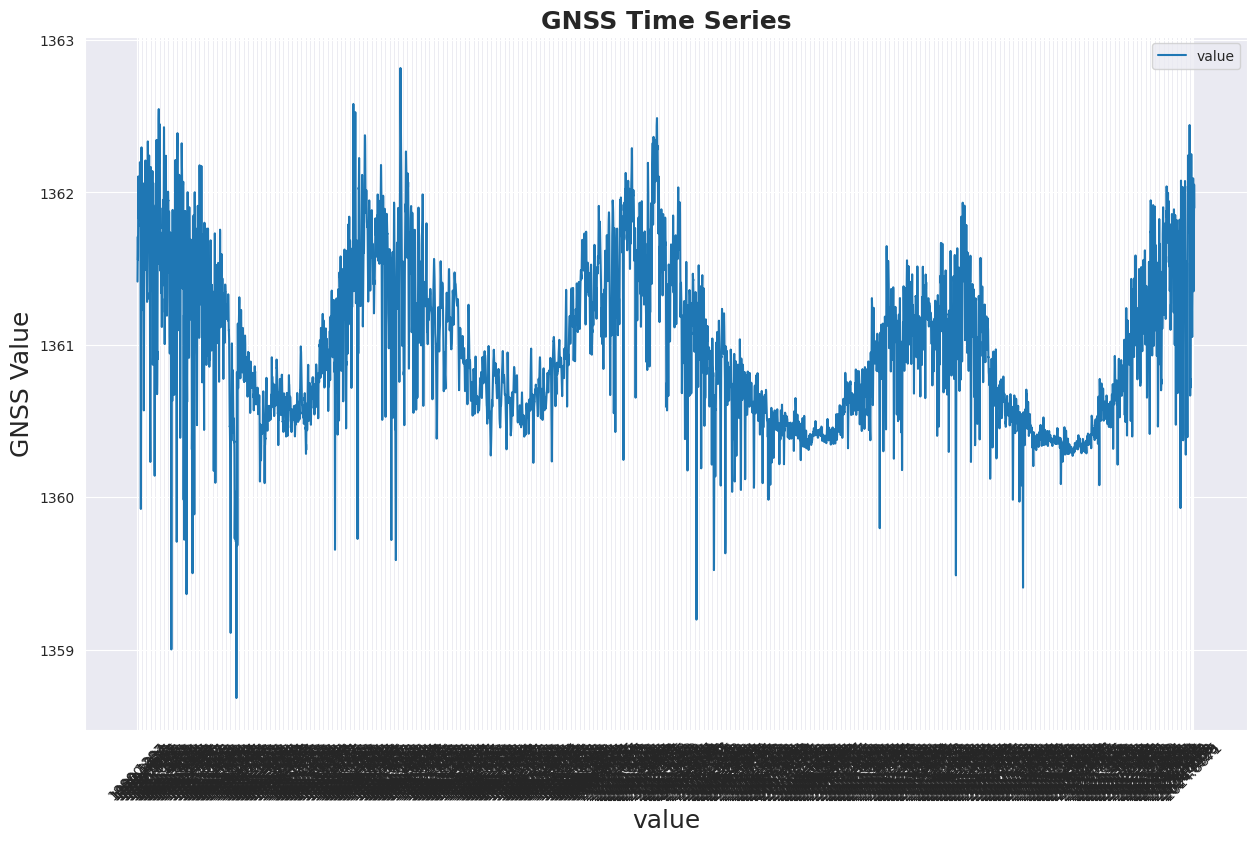

In [4]:
if args.vision:
    sns.set_style("darkgrid")
    plt.figure(figsize=(15, 9))
    plt.plot(data['period'], label='value')
    plt.xticks(range(0, data.shape[0], 20), data['time'].iloc[::20], rotation=45)
    plt.title("GNSS Time Series", fontsize=18, fontweight='bold')
    plt.xlabel('value', fontsize=18)
    plt.ylabel('GNSS Value', fontsize=18)
    plt.legend()

# 特征缩放
缩放为计算机可以看懂的语言

In [5]:
features = data[args.input_features]
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features)

target = data[args.output_features]
target_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaled = target_scaler.fit_transform(target)

one_scaler = MinMaxScaler(feature_range=(-1, 1))
one_scaled = one_scaler.fit_transform(data[['period']])

output_colnames = args.output_features
param = list(output_colnames)
param_index = range(len(param))
param_index_dict = dict(zip(param_index, param))

# 数据拆分

In [6]:
x_train, y_train, x_test, y_test = split_data(features_scaled, target_scaled, args.window_size)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)


x_train.shape =  (13070, 19, 2)
y_train.shape =  (13070, 1)
x_test.shape =  (3268, 19, 2)
y_test.shape =  (3268, 1)


# 进一步划分训练集和验证集 BEFORE 转换为 Torch 张量

In [7]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=args.train_test_ratio, random_state=args.random_state
)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (10456, 19, 2)
y_train.shape =  (10456, 1)
x_val.shape =  (2614, 19, 2)
y_val.shape =  (2614, 1)
x_test.shape =  (3268, 19, 2)
y_test.shape =  (3268, 1)


# 将 NumPy 数组转换为 Torch 张量 AFTER 分割

In [8]:
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(args.device)
x_val = torch.from_numpy(x_val).type(torch.Tensor).to(args.device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(args.device)
y_val = torch.from_numpy(y_val).type(torch.Tensor).to(args.device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(args.device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(args.device)

# 确保数据类型正确

In [9]:
assert isinstance(y_train, torch.Tensor), "y_train is not a tensor"

# 模型初始化

In [10]:
if args.model_name == 'LSTM':
    model = LSTM(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'LSTM_ekan':
    model = LSTM_ekan(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'BiLSTM':
    model = BiLSTM(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'BiLSTM_ekan':
    model = BiLSTM_ekan(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'GRUwGNN':
    model = GRUwGNN(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'GRU_ekanwGNN':
    model = GRU_ekanwGNN(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'LSTM_Attention':
    model = LSTM_Attention(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'CustomLSTM':
    model = CustomLSTM(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'GRU':
    model = GRU(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'ConvLSTM':
    model = ConvLSTM(
    input_dim=19,
    hidden_dim=args.hidden_dim,
    num_layers=args.n_layers,
    output_dim=len(args.output_features),
    kernel_size=args.kernel_size
)
elif args.model_name == 'TimeGNN':
    model = TimeGNN(
        # 移除loss参数
        input_dim=len(args.input_features),
        hidden_dim=args.hidden_dim,
        output_dim=len(args.output_features),
        seq_len=args.seq_len,
        batch_size=args.batch_size,
        aggregate=args.aggregate,
        keep_self_loops=args.keep_self_loops,
        enforce_consecutive=args.enforce_consecutive,
        block_size=args.block_size
    )
elif args.model_name == 'Informer':
    model = Informer(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, num_heads=args.num_heads, output_dim=len(args.output_features), dropout_rate=args.dropout)
elif args.model_name == 'ConvGRU':
    model = ConvGRU(
    input_dim=len(args.input_features),
    hidden_dim=args.hidden_dim,
    num_layers=args.n_layers,
    output_dim=len(args.output_features),
    kernel_size=args.kernel_size
)
elif args.model_name == 'VanillaLSTM':
    model = VanillaLSTM(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'GRU_ekan':
    model = GRU_ekan(input_dim=len(args.input_features), hidden_dim=args.hidden_dim, num_layers=args.n_layers, output_dim=len(args.output_features))
elif args.model_name == 'TCN':
    model = TemporalConvNet(num_inputs=len(args.input_features), num_outputs=len(args.output_features), num_channels=args.num_channels, kernel_size=args.kernel_size, dropout=args.dropout)
elif args.model_name == 'TCN_ekan':
    model = TemporalConvNet_ekan(num_inputs=len(args.input_features), num_outputs=len(args.output_features), num_channels=args.num_channels, kernel_size=args.kernel_size, dropout=args.dropout)
elif args.model_name == 'Transformer':
    model = TimeSeriesTransformer(input_dim=len(args.input_features), num_heads=args.num_heads, num_layers=args.n_layers, num_outputs=len(args.output_features), hidden_space=args.hidden_space, dropout_rate=args.dropout)
elif args.model_name == 'Transformer_ekan':
    model = TimeSeriesTransformer_ekan(input_dim=len(args.input_features), num_heads=args.num_heads, num_layers=args.n_layers, num_outputs=len(args.output_features), hidden_space=args.hidden_space, dropout_rate=args.dropout)
else:
    raise ValueError('请选择正确的模型名称')
model = model.to(args.device)

/root/miniconda3/envs/qwenvl/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# 损失函数和优化器

In [11]:
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=args.lr)


# 初始化 EarlyStopping（如果启用）

In [12]:
if args.use_early_stopping:
    checkpoint_path = f'../{args.model_name}/best_model.pt'
    early_stopping = EarlyStopping(patience=args.patience, verbose=True, delta=args.delta, path=checkpoint_path)
    print("启用早停机制。")
else:
    early_stopping = None
    print("未启用早停机制。")


启用早停机制。


# 初始化历史记录

In [13]:
train_MSE_hist = []
train_R2_hist = []
train_MAE_hist = []
val_MSE_hist = []
val_R2_hist = []
val_MAE_hist = []

output_dir_train = f'../{args.model_name}/train'
output_dir_val = f'../{args.model_name}/val'
output_dir_test = f'../{args.model_name}/test'  # 明确声明

os.makedirs(output_dir_train, exist_ok=True)
os.makedirs(output_dir_val, exist_ok=True)
os.makedirs(output_dir_test, exist_ok=True)  # 创建目录

# 开始训练

In [ ]:
start_time = time.time()
result = []
for epoch in range(args.num_epochs):
    # 训练模式
    model.train()
    y_train_pred = model(x_train)
    # 计算训练损失
    train_loss = criterion(y_train_pred, y_train)
    # 反向传播和优化
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()
    # 计算训练 R2 和 MAE
    train_r2 = r2_score(y_train.detach().cpu().numpy(), y_train_pred.detach().cpu().numpy())
    train_mae = mean_absolute_error(y_train.detach().cpu().numpy(), y_train_pred.detach().cpu().numpy())
    # 验证模式
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val)
        val_loss = criterion(y_val_pred, y_val)
        val_r2 = r2_score(y_val.detach().cpu().numpy(), y_val_pred.detach().cpu().numpy())
        val_mae = mean_absolute_error(y_val.detach().cpu().numpy(), y_val_pred.detach().cpu().numpy())
    # 打印训练和验证信息
    print(f"Epoch {epoch+1}/{args.num_epochs} | "
          f"Train MSE: {train_loss.item():.4f} | Train MAE: {train_mae:.4f} | Train R2: {train_r2:.4f} | "
          f"Val MSE: {val_loss.item():.4f} | Val MAE: {val_mae:.4f} | Val R2: {val_r2:.4f}")
    # 记录历史
    train_MSE_hist.append(train_loss.item())
    train_R2_hist.append(train_r2)
    train_MAE_hist.append(train_mae)
    val_MSE_hist.append(val_loss.item())
    val_R2_hist.append(val_r2)
    val_MAE_hist.append(val_mae)
    # 早停检查（如果启用）
    if args.use_early_stopping:
        early_stopping(val_loss.item(), model)
        if early_stopping.early_stop:
            print("早停机制触发，停止训练。")
            break


Epoch 1/10000 | Train MSE: 0.0482 | Train MAE: 0.1824 | Train R2: 0.1599 | Val MSE: 0.1003 | Val MAE: 0.2822 | Val R2: -0.7785
Validation loss decreased (inf --> 0.100301).  Saving model ...
Epoch 2/10000 | Train MSE: 0.1033 | Train MAE: 0.2848 | Train R2: -0.8020 | Val MSE: 0.0237 | Val MAE: 0.1199 | Val R2: 0.5792
Validation loss decreased (0.100301 --> 0.023732).  Saving model ...
Epoch 3/10000 | Train MSE: 0.0257 | Train MAE: 0.1236 | Train R2: 0.5520 | Val MSE: 0.0389 | Val MAE: 0.1627 | Val R2: 0.3101
EarlyStopping counter: 1 out of 250
Epoch 4/10000 | Train MSE: 0.0378 | Train MAE: 0.1609 | Train R2: 0.3403 | Val MSE: 0.0453 | Val MAE: 0.1785 | Val R2: 0.1963
EarlyStopping counter: 2 out of 250
Epoch 5/10000 | Train MSE: 0.0437 | Train MAE: 0.1754 | Train R2: 0.2381 | Val MSE: 0.0339 | Val MAE: 0.1519 | Val R2: 0.3988
EarlyStopping counter: 3 out of 250
Epoch 6/10000 | Train MSE: 0.0334 | Train MAE: 0.1510 | Train R2: 0.4168 | Val MSE: 0.0239 | Val MAE: 0.1233 | Val R2: 0.5755
E

# 记录训练时间

In [ ]:
training_time = time.time() - start_time
print("训练时间: {:.5f} 秒".format(training_time))


In [ ]:
# Custom interval prediction logic
if args.predict_start is not None or args.predict_end is not None:
    # Check if both start and end indices are provided
    if args.predict_start is None or args.predict_end is None:
        raise ValueError("Both --predict_start and --predict_end parameters must be provided")
    
    # Validate index validity
    if args.predict_start < args.window_size:
        raise ValueError(f"predict_start must be greater than or equal to the window size {args.window_size}")
    if args.predict_end >= len(features_scaled):
        raise ValueError(f"predict_end must be less than the data length {len(features_scaled)}")
    if args.predict_start > args.predict_end:
        raise ValueError("predict_start must be less than or equal to predict_end")

    # Generate input window data
    x_custom = []
    for i in range(args.predict_start, args.predict_end + 1):
        start_idx = i - args.window_size
        end_idx = i
        window_data = features_scaled[start_idx:end_idx, :]  # (window_size, n_features)
        x_custom.append(window_data)
    x_custom = np.array(x_custom)  # (n_samples, window_size, n_features)
    
    # Convert to tensor
    x_custom_tensor = torch.from_numpy(x_custom).float().to(args.device)
    
    # Perform prediction
    model.eval()
    with torch.no_grad():
        y_custom_pred = model(x_custom_tensor)
    
    # Inverse transform prediction results
    y_custom_pred_inv = target_scaler.inverse_transform(y_custom_pred.cpu().numpy())
    
    # Get true values
    y_custom_true = target_scaler.inverse_transform(target_scaled[args.predict_start:args.predict_end + 1])
    
    # Evaluation metrics
    custom_rmse = math.sqrt(mean_squared_error(y_custom_true, y_custom_pred_inv))
    custom_mae = mean_absolute_error(y_custom_true, y_custom_pred_inv)
    custom_r2 = r2_score(y_custom_true, y_custom_pred_inv)
    
    print(f"\nCustom Prediction Results ({args.predict_start}-{args.predict_end}):")
    print(f"RMSE: {custom_rmse:.5f}")
    print(f"MAE: {custom_mae:.5f}")
    print(f"R²: {custom_r2:.5f}")

    # Visualize results
    output_dir_custom = f'../{args.model_name}/custom'
    os.makedirs(output_dir_custom, exist_ok=True)
    
    for i in range(len(args.output_features)):
        feature_name = param_index_dict[i]
        plt.figure(figsize=(14, 6))
        
        # Generate x-axis labels
        if 'DATE' in data.columns:
            dates = data['DATE'].iloc[args.predict_start:args.predict_end + 1]
            x_axis = dates
        else:
            x_axis = range(args.predict_start, args.predict_end + 1)
        
        plt.plot(x_axis, y_custom_true[:, i], label='Actual Value', color='blue')
        plt.plot(x_axis, y_custom_pred_inv[:, i], label='Predicted Value', color='red', linestyle='--')
        
        plt.title(f'{feature_name} Prediction Comparison (Index {args.predict_start}-{args.predict_end})')
        plt.xlabel('Date' if 'DATE' in data.columns else 'Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        
        # Save the plot
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        plt.savefig(os.path.join(output_dir_custom, 
                    f'custom_{feature_name}_{args.predict_start}_to_{args.predict_end}_{timestamp}.png'))
        plt.close()

# Load the best model (if early stopping is enabled)
if args.use_early_stopping:
    model.load_state_dict(torch.load(checkpoint_path))

# Inverse transform prediction and true values
y_train_pred_inv = target_scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train_true = target_scaler.inverse_transform(y_train.detach().cpu().numpy())
y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.detach().cpu().numpy())
y_val_true = target_scaler.inverse_transform(y_val.detach().cpu().numpy())
y_test_pred = model(x_test)
y_test_pred_inv = target_scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test_full = target_scaler.inverse_transform(y_test.detach().cpu().numpy())

# Training set evaluation
train_rmse = math.sqrt(mean_squared_error(y_train_true, y_train_pred_inv))
train_mae = mean_absolute_error(y_train_true, y_train_pred_inv)
train_mse = mean_squared_error(y_train_true, y_train_pred_inv)
r2_train = r2_score(y_train_true, y_train_pred_inv)
print('Train Score: {:.5f} RMSE'.format(train_rmse))
print('Train MAE: {:.5f}'.format(train_mae))
print('Train MSE: {:.5f}'.format(train_mse))
print('Train R^2: {:.5f}'.format(r2_train))

# Validation set evaluation
val_rmse = math.sqrt(mean_squared_error(y_val_true, y_val_pred_inv))
val_mae = mean_absolute_error(y_val_true, y_val_pred_inv)
val_mse = mean_squared_error(y_val_true, y_val_pred_inv)
r2_val = r2_score(y_val_true, y_val_pred_inv)
print('Validation Score: {:.5f} RMSE'.format(val_rmse))
print('Validation MAE: {:.5f}'.format(val_mae))
print('Validation MSE: {:.5f}'.format(val_mse))
print('Validation R^2: {:.5f}'.format(r2_val))

# Test set evaluation
test_rmse = math.sqrt(mean_squared_error(y_test_full, y_test_pred_inv))
test_mae = mean_absolute_error(y_test_full, y_test_pred_inv)
test_mse = mean_squared_error(y_test_full, y_test_pred_inv)
r2_test = r2_score(y_test_full, y_test_pred_inv)
print('Test Score: {:.5f} RMSE'.format(test_rmse))
print('Test MAE: {:.5f}'.format(test_mae))
print('Test MSE: {:.5f}'.format(test_mse))
print('Test R^2: {:.5f}'.format(r2_test))

# Save model evaluation results
file_path = 'model_scores.csv'
# Create a DataFrame containing the current model results
data_scores = {
    "Model Name": [args.model_name],
    "Train RMSE": [train_rmse],
    "Train MAE": [train_mae],
    "Train MSE": [train_mse],
    "Train R^2": [r2_train],
    "Validation RMSE": [val_rmse],
    "Validation MAE": [val_mae],
    "Validation MSE": [val_mse],
    "Validation R^2": [r2_val],
    "Test RMSE": [test_rmse],
    "Test MAE": [test_mae],
    "Test MSE": [test_mse],
    "Test R^2": [r2_test],
    "Training Time (s)": [training_time],
    # Record hyperparameters
    "Learning Rate": [args.lr],
    "Hidden Dim": [args.hidden_dim],
    "Num Layers": [args.n_layers],
    "Dropout": [args.dropout],
    "Window Size": [args.window_size],
    "Patience": [args.patience],
    "Delta": [args.delta]
}
# Ensure each run's record is unique by adding a timestamp to the model name
current_time_str_filename = time.strftime("%Y%m%d_%H%M%S", time.localtime())
df_scores = pd.DataFrame(data_scores, index=[f"{args.model_name}_{current_time_str_filename}"])
# Check if the file exists
if Path(file_path).exists():
    # File exists, append data
    df_scores.to_csv(file_path, mode='a', header=False, index=True)
else:
    # File does not exist, create the file and write data
    df_scores.to_csv(file_path, index=True)

# Inverse transform predictions for visualization
y_test_pred_full = y_test_pred_inv
y_test_full = y_test_full  # Already inverse transformed

# Create output directories
output_dir_train = f'../{args.model_name}/train'
output_dir_val = f'../{args.model_name}/val'
output_dir_test = f'../{args.model_name}/test'
os.makedirs(output_dir_train, exist_ok=True)
os.makedirs(output_dir_val, exist_ok=True)
os.makedirs(output_dir_test, exist_ok=True)

# Get the date or sample index from the original data
if 'DATE' in data.columns:
    dates = pd.to_datetime(data['DATE'])
    x_axis = dates
else:
    x_axis = range(len(data))

# Plot predictions for training, validation, and test sets
for i in range(len(args.output_features)):
    feature_name = param_index_dict[i]
    
    # Get the current time string
    current_time_str_filename = time.strftime("%Y%m%d_%H%M%S", time.localtime())
    
    # Plot training set prediction results
    plt.figure(figsize=(14, 6))
    plt.plot(x_axis[args.window_size:args.window_size + len(y_train_true)], y_train_true[:, i], label='Actual Train', color='blue')
    plt.plot(x_axis[args.window_size:args.window_size + len(y_train_pred_inv)], y_train_pred_inv[:, i], label=f'Train Prediction ({args.model_name})', color='orange')
    plt.title(f'Training Set Prediction vs Actual ({feature_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Date' if 'DATE' in data.columns else 'Index', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Add timestamp to filename
    plt.savefig(os.path.join(output_dir_train, f'{feature_name}_train_{current_time_str_filename}.png'))
    plt.close()
    
    # Plot validation set prediction results
    plt.figure(figsize=(14, 6))
    plt.plot(x_axis[args.window_size + len(y_train_true):args.window_size + len(y_train_true) + len(y_val_true)], y_val_true[:, i], label='Actual Validation', color='green')
    plt.plot(x_axis[args.window_size + len(y_train_true):args.window_size + len(y_train_true) + len(y_val_pred_inv)], y_val_pred_inv[:, i], label=f'Validation Prediction ({args.model_name})', color='red')
    plt.title(f'Validation Set Prediction vs Actual ({feature_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Date' if 'DATE' in data.columns else 'Index', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Add timestamp to filename
    plt.savefig(os.path.join(output_dir_val, f'{feature_name}_val_{current_time_str_filename}.png'))
    plt.close()
    
    # Plot test set prediction results
    plt.figure(figsize=(14, 6))
    plt.plot(x_axis[args.window_size + len(y_train_true) + len(y_val_true):args.window_size + len(y_train_true) + len(y_val_true) + len(y_test_full)], y_test_full[:, i], label='Actual Test', color='purple')
    plt.plot(x_axis[args.window_size + len(y_train_true) + len(y_val_true):args.window_size + len(y_train_true) + len(y_val_true) + len(y_test_pred_inv)], y_test_pred_inv[:, i], label=f'Test Prediction ({args.model_name})', color='brown')
    plt.title(f'Test Set Prediction vs Actual ', fontsize=16, fontweight='bold')
    plt.xlabel('Date' if 'DATE' in data.columns else 'Index', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Add timestamp to filename
    plt.savefig(os.path.join(output_dir_test, f'{feature_name}_test_{current_time_str_filename}.png'))
    plt.close()

print("All prediction result plots have been completed and saved.")

In [ ]:
if 'DATE' in data.columns:
    time_axis = pd.to_datetime(data['DATE'])
else:
    time_axis = pd.RangeIndex(start=0, stop=len(data))

# 然后在保存自定义预测结果时使用这个time_axis
if args.predict_start is not None and args.predict_end is not None:
    custom_time_slice = slice(args.predict_start, args.predict_end + 1)
    custom_true = target_scaler.inverse_transform(target_scaled[args.predict_start:args.predict_end + 1])
    
    # 创建自定义预测的DataFrame
    df_custom = pd.DataFrame({
        'Time': time_axis[custom_time_slice],
        'Actual': custom_true.flatten(),
        'Predicted': y_custom_pred_inv.flatten()
    })# 在评估指标计算后的位置添加以下代码（通常在模型训练结束后，可视化代码之前）

# 创建保存CSV的目录
output_dir_csv = f'../{args.model_name}/csv'
os.makedirs(output_dir_csv, exist_ok=True)

def save_pred_to_csv(data_dict, filename_prefix):
    """保存预测结果到CSV的通用函数"""
    current_time_str = time.strftime("%Y%m%d_%H%M%S")
    
    # 获取时间或索引信息
    if 'DATE' in data.columns:
        dates = pd.to_datetime(data['DATE'])
        time_axis = dates
    else:
        time_axis = pd.RangeIndex(start=0, stop=len(data))
    
    for i, feature_name in param_index_dict.items():
        # 创建包含完整信息的DataFrame
        df = pd.DataFrame({
            'Time': time_axis[data_dict['time_slice']],
            'Actual': data_dict['true'][:, i],
            'Predicted': data_dict['pred'][:, i]
        })
        
        # 生成带时间戳的文件名
        filename = f"{filename_prefix}_{feature_name}_{current_time_str}.csv"
        filepath = os.path.join(output_dir_csv, filename)
        
        # 保存到CSV
        df.to_csv(filepath, index=False)
        print(f"Saved {filename_prefix} predictions for {feature_name} to {filepath}")

# 保存训练集预测结果
save_pred_to_csv({
    'time_slice': slice(args.window_size, args.window_size + len(y_train_true)),
    'true': y_train_true,
    'pred': y_train_pred_inv
}, "train")

# 保存验证集预测结果
val_start = args.window_size + len(y_train_true)
val_end = val_start + len(y_val_true)
save_pred_to_csv({
    'time_slice': slice(val_start, val_end),
    'true': y_val_true,
    'pred': y_val_pred_inv
}, "val")

# 保存测试集预测结果
test_start = val_end
test_end = test_start + len(y_test_full)
save_pred_to_csv({
    'time_slice': slice(test_start, test_end),
    'true': y_test_full,
    'pred': y_test_pred_inv
}, "test")

# 保存自定义预测区域结果（如果指定）
if args.predict_start is not None and args.predict_end is not None:
    custom_time_slice = slice(args.predict_start, args.predict_end + 1)
    custom_true = target_scaler.inverse_transform(target_scaled[args.predict_start:args.predict_end + 1])
    
    # 创建自定义预测的DataFrame
    df_custom = pd.DataFrame({
        'Time': time_axis[custom_time_slice],
        'Actual': custom_true.flatten(),
        'Predicted': y_custom_pred_inv.flatten()
    })
    
    # 生成文件名
    current_time_str = time.strftime("%Y%m%d_%H%M%S")
    filename = f"custom_{args.predict_start}_to_{args.predict_end}_{current_time_str}.csv"
    filepath = os.path.join(output_dir_csv, filename)
    
    # 保存到CSV
    df_custom.to_csv(filepath, index=False)
    print(f"Saved custom predictions ({args.predict_start}-{args.predict_end}) to {filepath}")
import pyarrow# Custom interval prediction logic
if args.predict_start is not None or args.predict_end is not None:
    # Check if both start and end indices are provided
    if args.predict_start is None or args.predict_end is None:
        raise ValueError("Both --predict_start and --predict_end parameters must be provided")
    
    # Validate index validity
    if args.predict_start < args.window_size:
        raise ValueError(f"predict_start must be greater than or equal to the window size {args.window_size}")
    if args.predict_end >= len(features_scaled):
        raise ValueError(f"predict_end must be less than the data length {len(features_scaled)}")
    if args.predict_start > args.predict_end:
        raise ValueError("predict_start must be less than or equal to predict_end")

    # Generate input window data
    x_custom = []
    for i in range(args.predict_start, args.predict_end + 1):
        start_idx = i - args.window_size
        end_idx = i
        window_data = features_scaled[start_idx:end_idx, :]  # (window_size, n_features)
        x_custom.append(window_data)
    x_custom = np.array(x_custom)  # (n_samples, window_size, n_features)

    # Convert to tensor
    x_custom_tensor = torch.from_numpy(x_custom).float().to(args.device)

    # Perform prediction
    model.eval()
    with torch.no_grad():
        y_custom_pred = model(x_custom_tensor)

    # Inverse transform prediction results
    y_custom_pred_inv = target_scaler.inverse_transform(y_custom_pred.cpu().numpy())

    # Get true values
    y_custom_true = target_scaler.inverse_transform(target_scaled[args.predict_start:args.predict_end + 1])

    # Evaluation metrics
    custom_rmse = math.sqrt(mean_squared_error(y_custom_true, y_custom_pred_inv))
    custom_mae = mean_absolute_error(y_custom_true, y_custom_pred_inv)
    custom_r2 = r2_score(y_custom_true, y_custom_pred_inv)
    print(f"\nCustom Prediction Results ({args.predict_start}-{args.predict_end}):")
    print(f"RMSE: {custom_rmse:.5f}")
    print(f"MAE: {custom_mae:.5f}")
    print(f"R²: {custom_r2:.5f}")

    # Visualize results
    output_dir_custom = f'../{args.model_name}/custom'
    os.makedirs(output_dir_custom, exist_ok=True)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    # Generate x-axis labels
    if 'DATE' in data.columns:
        dates = data['DATE'].iloc[args.predict_start:args.predict_end + 1]
        x_axis = dates
    else:
        x_axis = range(args.predict_start, args.predict_end + 1)

    for i in range(len(args.output_features)):
        feature_name = param_index_dict[i]
        plt.figure(figsize=(14, 6))
        plt.plot(x_axis, y_custom_true[:, i], label='Actual Value', color='blue')
        plt.plot(x_axis, y_custom_pred_inv[:, i], label='Predicted Value', color='red', linestyle='--')
        plt.title(f'{feature_name} Prediction Comparison (Index {args.predict_start}-{args.predict_end})')
        plt.xlabel('Date' if 'DATE' in data.columns else 'Index')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(output_dir_custom, 
                    f'custom_{feature_name}_{args.predict_start}_to_{args.predict_end}_{timestamp}.png'))
        plt.close()

    # =================================================================
    # 新增数据保存代码（开始）
    # =================================================================
    # 创建CSV保存目录
    output_csv_dir = os.path.normpath(
        os.path.join(f'../{args.model_name}', 'csv_data', f'predictions_{args.predict_start}-{args.predict_end}')
    )
    os.makedirs(output_csv_dir, exist_ok=True)

    # 构建完整数据记录
    full_records = []
    for idx in range(len(x_axis)):
        record = {
            "global_index": args.predict_start + idx,
            "window_start": (args.predict_start + idx) - args.window_size,
            "window_end": args.predict_start + idx
        }
        
        # 添加日期信息
        if 'DATE' in data.columns:
            record["date"] = str(data['DATE'].iloc[args.predict_start + idx])
        
        # 添加特征数据
        for feat_idx, feat_name in param_index_dict.items():
            record[f"{feat_name}_actual"] = float(y_custom_true[idx, feat_idx])
            record[f"{feat_name}_pred"] = float(y_custom_pred_inv[idx, feat_idx])
            record[f"{feat_name}_abs_error"] = float(abs(y_custom_true[idx, feat_idx] - y_custom_pred_inv[idx, feat_idx]))
        
        full_records.append(record)

    # 创建DataFrame并优化数据类型
    df_full = pd.DataFrame(full_records)
    
    # 设置索引
    index_columns = []
    if 'DATE' in data.columns:
        df_full['date'] = pd.to_datetime(df_full['date'])
        index_columns.append('date')
    index_columns.extend(['global_index', 'window_start', 'window_end'])
    df_full = df_full.set_index(index_columns)

    # 保存完整数据集（CSV + Parquet）
    full_csv_path = os.path.join(output_csv_dir, f'full_predictions_{timestamp}.csv')
    full_parquet_path = os.path.join(output_csv_dir, f'full_predictions_{timestamp}.parquet')
    df_full.to_csv(full_csv_path, float_format='%.5f')
    df_full.to_parquet(full_parquet_path)
    print(f"\n[SAVE] Full prediction data saved to:")
    print(f"CSV: {os.path.abspath(full_csv_path)}")
    print(f"Parquet: {os.path.abspath(full_parquet_path)}")

    # 分特征保存
    for feat_idx in range(len(args.output_features)):
        feat_name = param_index_dict[feat_idx]
        
        # 构建特征数据集
        feat_data = {
            'actual': y_custom_true[:, feat_idx],
            'predicted': y_custom_pred_inv[:, feat_idx],
            'abs_error': np.abs(y_custom_true[:, feat_idx] - y_custom_pred_inv[:, feat_idx])
        }
        
        # 添加元数据
        feat_df = pd.DataFrame(feat_data, index=x_axis)
        if 'DATE' in data.columns:
            feat_df.index.name = 'date'
        else:
            feat_df['global_index'] = range(args.predict_start, args.predict_end + 1)
            feat_df = feat_df.set_index('global_index')
        
        # 保存文件
        feat_csv_path = os.path.join(output_csv_dir, f'{feat_name}_predictions_{timestamp}.csv')
        feat_parquet_path = os.path.join(output_csv_dir, f'{feat_name}_predictions_{timestamp}.parquet')
        feat_df.to_csv(feat_csv_path, float_format='%.5f')
        feat_df.to_parquet(feat_parquet_path)
        print(f"\n[SAVE] {feat_name} predictions saved to:")
        print(f"CSV: {os.path.abspath(feat_csv_path)}")
        print(f"Parquet: {os.path.abspath(feat_parquet_path)}")

    # =================================================================
    # 新增数据保存代码（结束）
    # =================================================================

# Load the best model (if early stopping is enabled)
if args.use_early_stopping:
    model.load_state_dict(torch.load(checkpoint_path))

# Inverse transform prediction and true values
y_train_pred_inv = target_scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train_true = target_scaler.inverse_transform(y_train.detach().cpu().numpy())
y_val_pred_inv = target_scaler.inverse_transform(y_val_pred.detach().cpu().numpy())
y_val_true = target_scaler.inverse_transform(y_val.detach().cpu().numpy())
y_test_pred = model(x_test)
y_test_pred_inv = target_scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test_full = target_scaler.inverse_transform(y_test.detach().cpu().numpy())

# Training set evaluation
train_rmse = math.sqrt(mean_squared_error(y_train_true, y_train_pred_inv))
train_mae = mean_absolute_error(y_train_true, y_train_pred_inv)
train_mse = mean_squared_error(y_train_true, y_train_pred_inv)
r2_train = r2_score(y_train_true, y_train_pred_inv)
print('Train Score: {:.5f} RMSE'.format(train_rmse))
print('Train MAE: {:.5f}'.format(train_mae))
print('Train MSE: {:.5f}'.format(train_mse))
print('Train R^2: {:.5f}'.format(r2_train))

# Validation set evaluation
val_rmse = math.sqrt(mean_squared_error(y_val_true, y_val_pred_inv))
val_mae = mean_absolute_error(y_val_true, y_val_pred_inv)
val_mse = mean_squared_error(y_val_true, y_val_pred_inv)
r2_val = r2_score(y_val_true, y_val_pred_inv)
print('Validation Score: {:.5f} RMSE'.format(val_rmse))
print('Validation MAE: {:.5f}'.format(val_mae))
print('Validation MSE: {:.5f}'.format(val_mse))
print('Validation R^2: {:.5f}'.format(r2_val))

# Test set evaluation
test_rmse = math.sqrt(mean_squared_error(y_test_full, y_test_pred_inv))
test_mae = mean_absolute_error(y_test_full, y_test_pred_inv)
test_mse = mean_squared_error(y_test_full, y_test_pred_inv)
r2_test = r2_score(y_test_full, y_test_pred_inv)
print('Test Score: {:.5f} RMSE'.format(test_rmse))
print('Test MAE: {:.5f}'.format(test_mae))
print('Test MSE: {:.5f}'.format(test_mse))
print('Test R^2: {:.5f}'.format(r2_test))

# Save model evaluation results
file_path = 'model_scores.csv'
# Create a DataFrame containing the current model results
data_scores = {
    "Model Name": [args.model_name],
    "Train RMSE": [train_rmse],
    "Train MAE": [train_mae],
    "Train MSE": [train_mse],
    "Train R^2": [r2_train],
    "Validation RMSE": [val_rmse],
    "Validation MAE": [val_mae],
    "Validation MSE": [val_mse],
    "Validation R^2": [r2_val],
    "Test RMSE": [test_rmse],
    "Test MAE": [test_mae],
    "Test MSE": [test_mse],
    "Test R^2": [r2_test],
    "Training Time (s)": [training_time],
    # Record hyperparameters
    "Learning Rate": [args.lr],
    "Hidden Dim": [args.hidden_dim],
    "Num Layers": [args.n_layers],
    "Dropout": [args.dropout],
    "Window Size": [args.window_size],
    "Patience": [args.patience],
    "Delta": [args.delta]
}
# Ensure each run's record is unique by adding a timestamp to the model name
current_time_str_filename = time.strftime("%Y%m%d_%H%M%S", time.localtime())
df_scores = pd.DataFrame(data_scores, index=[f"{args.model_name}_{current_time_str_filename}"])
# Check if the file exists
if Path(file_path).exists():
    # File exists, append data
    df_scores.to_csv(file_path, mode='a', header=False, index=True)
else:
    # File does not exist, create the file and write data
    df_scores.to_csv(file_path, index=True)

# Inverse transform predictions for visualization
y_test_pred_full = y_test_pred_inv
y_test_full = y_test_full  # Already inverse transformed

# Create output directories
output_dir_train = f'../{args.model_name}/train'
output_dir_val = f'../{args.model_name}/val'
output_dir_test = f'../{args.model_name}/test'
os.makedirs(output_dir_train, exist_ok=True)
os.makedirs(output_dir_val, exist_ok=True)
os.makedirs(output_dir_test, exist_ok=True)

# Get the date or sample index from the original data
if 'DATE' in data.columns:
    dates = pd.to_datetime(data['DATE'])
    x_axis = dates
else:
    x_axis = range(len(data))

# Plot predictions for training, validation, and test sets
for i in range(len(args.output_features)):
    feature_name = param_index_dict[i]
    
    # Get the current time string
    current_time_str_filename = time.strftime("%Y%m%d_%H%M%S", time.localtime())
    
    # Plot training set prediction results
    plt.figure(figsize=(14, 6))
    plt.plot(x_axis[args.window_size:args.window_size + len(y_train_true)], y_train_true[:, i], label='Actual Train', color='blue')
    plt.plot(x_axis[args.window_size:args.window_size + len(y_train_pred_inv)], y_train_pred_inv[:, i], label=f'Train Prediction ({args.model_name})', color='orange')
    plt.title(f'Training Set Prediction vs Actual ({feature_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Date' if 'DATE' in data.columns else 'Index', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Add timestamp to filename
    plt.savefig(os.path.join(output_dir_train, f'{feature_name}_train_{current_time_str_filename}.png'))
    plt.close()
    
    # Plot validation set prediction results
    plt.figure(figsize=(14, 6))
    plt.plot(x_axis[args.window_size + len(y_train_true):args.window_size + len(y_train_true) + len(y_val_true)], y_val_true[:, i], label='Actual Validation', color='green')
    plt.plot(x_axis[args.window_size + len(y_train_true):args.window_size + len(y_train_true) + len(y_val_pred_inv)], y_val_pred_inv[:, i], label=f'Validation Prediction ({args.model_name})', color='red')
    plt.title(f'Validation Set Prediction vs Actual ({feature_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Date' if 'DATE' in data.columns else 'Index', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Add timestamp to filename
    plt.savefig(os.path.join(output_dir_val, f'{feature_name}_val_{current_time_str_filename}.png'))
    plt.close()
    
    # Plot test set prediction results
    plt.figure(figsize=(14, 6))
    plt.plot(x_axis[args.window_size + len(y_train_true) + len(y_val_true):args.window_size + len(y_train_true) + len(y_val_true) + len(y_test_full)], y_test_full[:, i], label='Actual Test', color='purple')
    plt.plot(x_axis[args.window_size + len(y_train_true) + len(y_val_true):args.window_size + len(y_train_true) + len(y_val_true) + len(y_test_pred_inv)], y_test_pred_inv[:, i], label=f'Test Prediction ({args.model_name})', color='brown')
    plt.title(f'Test Set Prediction vs Actual ', fontsize=16, fontweight='bold')
    plt.xlabel('Date' if 'DATE' in data.columns else 'Index', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    # Add timestamp to filename
    plt.savefig(os.path.join(output_dir_test, f'{feature_name}_test_{current_time_str_filename}.png'))
    plt.close()

print("All prediction result plots have been completed and saved.")